In [1]:
###%matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from pprint import pprint
from matplotlib.lines import Line2D
from glob import glob 
import sys

from scipy.special import comb
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model

def discrete_cmap(N, base_cmap=None):
    """
    https://gist.github.com/jakevdp/91077b0cae40f8f8244a
    Create an N-bin discrete colormap from the specified input map
    """

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def get_gen_ind(txt):
    s = (txt.split('.')[-2]).split('_')[-2:]
    print(txt.split('.')[-2])
    print(txt, s)
    return int(s[0][3:]), int(s[1][3:])

def filter_spikes(spikes, start_t, end_t):
    f = []
    for i, times in enumerate(spikes):
        if len(times) == 0:
            f.append([])
            continue
        
        ts = np.array(times)
        whr = np.where(np.logical_and(start_t <= ts, ts < end_t))[0]
        
        if len(whr) == 0:
            f.append([])
            continue
        
        f.append(ts[whr].tolist())
    
    return f
            
def spikes_to_classes(spikes, sample_dt, sample_indices):
    classes = []
    for times in spikes:
        l = []
        for t in times:
            idx = int(t // sample_dt)
            ind_idx = sample_indices[ idx ] - 1
#             print(t, idx, ind_idx)
            l.append(ind_idx)
        classes.append(l)
    return classes
    

def spikes_to_vectors(spikes, start_t, end_t, sample_dt, labels, n_classes, n_out):
    d = {l: [] for l in range(n_classes)}
    counts = [0 for l in range(n_classes)]
    for sample, st in enumerate(np.arange(start_t, end_t + 1, sample_dt)):

        et = st + sample_dt
        idx = int(st // sample_dt)
        
        c = labels[ idx ] - 1
        counts[c] += 1
        
        v = np.zeros(n_out)
        for i, times in enumerate(spikes):
            if len(times) == 0:
                continue
            
            ts = np.asarray(times)
            whr = np.where(np.logical_and(st <= ts, ts < et))[0]

            if len(whr):
                v[i] = 1
        d[c].append(v)
        
    print(counts)

    return d

def accum_vectors(vecs):
    d = {k: np.zeros_like(vecs[k][0], dtype='uint')\
                                         for k in vecs}
    
    for k in vecs:
        for v in vecs[k]:
            d[k][:] = np.logical_or(d[k], np.asarray(v) > 0)
    return d

def accuracy(centroids, tests):
    accs = {}
    for cls, vs in tests.items():
        cols = {}
        for k, ctr in centroids.items():
            cols[k] = [int(np.sum(np.logical_and(ctr, v))) for v in vs]

        accs[cls] = cols

    return accs

def to_dict(npz):
    d = {}
    for k in npz.keys():
        try:
            d[k] = npz[k].item()
        except:
            d[k] = npz[k]
    return d

In [2]:
# result_files = sorted(glob('./L2L-OMNIGLOT/run_results/*.npz'))
# for f in result_files:
#     tmp = to_dict( np.load(f, allow_pickle=True) )
#     if not tmp['died']:
#         spks = tmp['recs']['output'][0]['spikes']
#         for k in spks:
#             if len(k):
#                 print(np.min(k), np.max(k))


/home/gp283/l2l-omniglot
['./data_gen000182_ind000018.npz']
dict_keys(['labels', 'n_zones', 'spikes', 'shapes'])
[0.0]


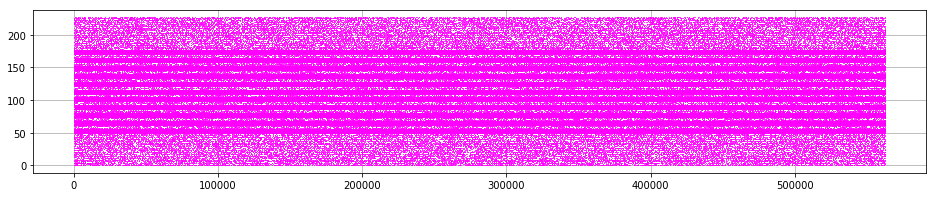

In [14]:
# result_files = sorted(glob('./L2L-OMNIGLOT/run_results/*.npz'))
print(os.getcwd())
result_files = sorted(glob('./data_gen*_ind*.npz'))
print(result_files)
c = ['red', 'green', 'blue', 'magenta']
LAYER = 3
for f in result_files[-1:]:
    tmp = to_dict( np.load(f, allow_pickle=True) )
    inputs = tmp['input']
    print(inputs.keys())
    spikes = inputs['spikes']
    print(sorted(spikes.keys()))
    
#     print(inputs['spikes'])
    for st in sorted(spikes.keys()):
        
        for layer in spikes[st]:
            if layer == LAYER:
                plt.figure(figsize=(16, 3))
                for nid, times in enumerate(spikes[st][layer]):
#                     if nid < 190:
#                         continue
                    ts = np.array(times)
#                     ttt = ts[ts < 200.0]
                    ttt = ts
                    plt.plot(ttt, np.ones_like(ttt) * nid, 
                             marker='.', markersize=2, color=c[layer], 
                             linestyle='none', markeredgewidth=0)
                plt.grid()
            plt.show()
#     for k in spks:
#         if len(k):
#             print(np.min(k), np.max(k))


/home/gp283/l2l-omniglot
./data_gen000182_ind000018.npz
dict_keys(['input', 'db_name', 'analysis', 'fitness', 'died', 'recs', 'params', 'weights'])
dict_keys(['input', 'output'])
dict_keys([0, 1, 2, 3])
died = False
228 15.0996688705415 228
{0: [56, 56], 1: [56, 56], 2: [19, 12], 3: [19, 12]}


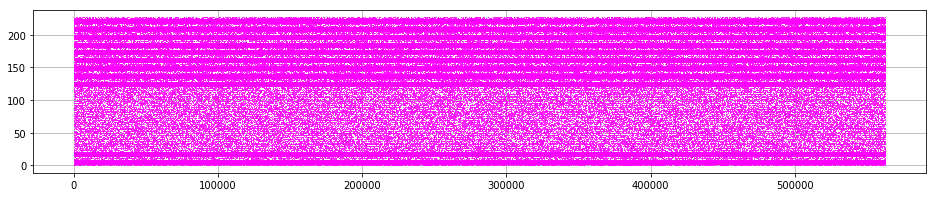

In [15]:
# result_files = sorted(glob('./L2L-OMNIGLOT/run_results/*.npz'))
result_files = sorted(glob('./data_gen*_ind*.npz'))

print(os.getcwd())
c = ['red', 'green', 'blue', 'magenta']
for f in result_files[-1:]:
    print(f)
    tmp = to_dict( np.load(f, allow_pickle=True) )
    
    print(tmp.keys())
    print(tmp['recs'].keys())
    print(tmp['recs']['input'].keys())

    print('died = {}'.format(tmp['died']))
    
    spks = tmp['recs']['input'][LAYER]['spikes']
    print(len(spks), np.sqrt(len(spks)), 19*12)
    print(tmp['input']['shapes'])
    
    plt.figure(figsize=(16, 3))
    for nid, times in enumerate(spks):
#         if nid < 40 or nid > 75:
#             continue
        ts = np.array(times)
#         ttt = ts[ts < 200.0]
        ttt = ts
        plt.plot(ttt, np.ones_like(ttt) * nid, 
                 marker='.', markersize=2, color=c[LAYER], 
                 linestyle='none', markeredgewidth=0)
    plt.grid()
    plt.show()
#     for k in spks:
#         if len(k):
#             print(np.min(k), np.max(k))



/home/gp283/l2l-omniglot
./last_gen/data_gen0000000041_ind0000000000.npz
died = False



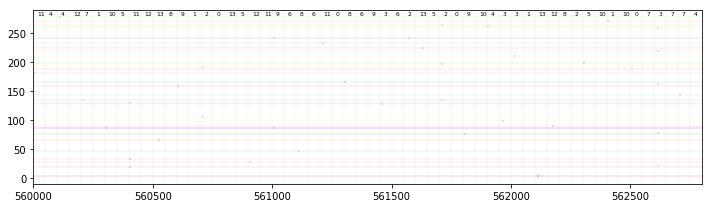

In [131]:

plt.close('all')

# result_files = sorted(glob('./L2L-OMNIGLOT/run_results/*.npz'))
result_files = sorted(glob('./last_gen/data_gen*_ind*.npz'))

print(os.getcwd())
c = ['red', 'green', 'blue', 'magenta']
# for f in [result_files[1]]:
for f in result_files[:1]:
    print(f)
    tmp = to_dict( np.load(f, allow_pickle=True) )
#     print(tmp.keys())
    print('died = {}\n'.format(tmp['died']))
    
    sim_p = tmp['params']['sim']
    ind_p = tmp['params']['ind'] 
    recs = tmp['recs']
    duration = sim_p['duration']
    n_test = sim_p['test_per_class']
    n_class = sim_p['num_classes']
    dt = sim_p['sample_dt']
    n_out = sim_p['output_size']
    labels = tmp['input']['labels']
    
#     print(sim_p)
#     print()
#     print(ind_p)
    
#     print(tmp)
    
    cmap = discrete_cmap(n_class, base_cmap='hsv')

    start_t = duration - (n_test * n_class * dt)
    
    spks = recs['output'][0]['spikes']
    plt.figure(figsize=(10, 3))
    ax = plt.subplot(1, 1, 1)

    for s in np.arange(start_t, duration, dt):
        plt.axvline(s, linestyle='--', color='gray', linewidth=0.1)
        idx = int( s//dt )
        lbl = labels[idx]
        plt.text(s+dt//3, n_out, lbl, fontsize=6)

    for nid, times in enumerate(spks):
        ts = np.asarray(times)
        whr = np.where(ts >= start_t)
        for t in ts[whr]:
            idx = int( t//dt )
            lbl = labels[idx]
            plt.axhline(nid, color=cmap(float(lbl)/n_class), alpha=1., linewidth=0.1)
            
        plt.plot(ts[whr], np.ones_like(ts[whr]) * nid, 
                 marker='+', markersize=2, color='black', 
                 linestyle='none', markeredgewidth=0.1)
    ax.set_xlim(start_t, duration)
    ax.set_ylim(-10, n_out+10)
    plt.tight_layout()
    plt.savefig('test_colors.pdf')
    plt.show()


In [133]:
from omnigloter import config, utils, analyse_network as analysis

plt.close('all')

# result_files = sorted(glob('./L2L-OMNIGLOT/run_results/*.npz'))
# result_files = sorted(glob('./last_gen/data_gen*_ind*.npz'))

print(os.getcwd())
c = ['red', 'green', 'blue', 'magenta']
for f in [result_files[0]]:
    print(f)
    tmp = to_dict( np.load(f, allow_pickle=True) )
#     print(tmp.keys())
    print('died = {}\n'.format(tmp['died']))
    
    sim_p = tmp['params']['sim']
    ind_p = tmp['params']['ind'] 
    recs = tmp['recs']
    duration = sim_p['duration']
    n_test = sim_p['test_per_class']
    n_class = sim_p['num_classes']
    dt = sim_p['sample_dt']
    n_out = sim_p['output_size']
    labels = tmp['input']['labels']
    spks = recs['output'][0]['spikes']
    start_t = duration - (n_test * n_class * dt)
    print(len(spks))
    test_spikes, test_labels = analysis.get_test_region(spks, start_t, labels, dt)
    
#     apc, ipc = analysis.spiking_per_class(labels, test_spikes, start_t, duration, dt)
    apc, ipc = analysis.spiking_per_class(labels, spks, start_t, duration, dt)
    
    
    


/home/gp283/l2l-omniglot
./last_gen/data_gen0000000041_ind0000000000.npz
died = False

280


In [156]:
apc = {0: {248: np.array([112067.]), 276: np.array([113671.])}, 1: {105: np.array([112406.]), 276: np.array([112306.]), 85: np.array([113403.])}, 2: {161: np.array([112903.]), 276: np.array([112903.]), 270: np.array([112904.]), 102: np.array([112904.]), 95: np.array([112903.])}, 3: {99: np.array([113461.]), 238: np.array([113110.])}, 4: {122: np.array([114704.]), 131: np.array([114217.]), 206: np.array([114743.])}, 5: {105: np.array([112706.]), 266: np.array([114108.]), 100: np.array([112706.]), 270: np.array([114108.])}, 6: {5: np.array([114507.]), 206: np.array([113592.])}, 7: {36: np.array([112506.]), 276: np.array([112107.]), 173: np.array([112507.])}, 8: {206: np.array([113856.])}, 9: {43: np.array([113926.]), 132: np.array([113927.]), 150: np.array([113927.]), 230: np.array([113006.])}, 10: {89: np.array([112005.]), 257: np.array([112005.]), 149: np.array([112005.]), 95: np.array([112006.])}, 11: {89: np.array([113705.])}, 12: {144: np.array([113505.]), 40: np.array([112661.]), 178: np.array([113504.]), 121: np.array([114410.]), 149: np.array([112209.]), 25: np.array([113504.]), 88: np.array([112209.]), 89: np.array([112209.]), 87: np.array([113504.]), 206: np.array([113504.]), 95: np.array([112209.])}, 13: {56: np.array([112354.]), 145: np.array([114607.]), 242: np.array([112576.])}}
overlap_score = analysis.overlap_score(apc, n_out)
print(overlap_score)

276 [105, 276, 85] 0 1
276 [161, 276, 102, 270, 95] 0 2
276 [276, 36, 173] 0 7
276 [161, 276, 102, 270, 95] 1 2
105 [105, 266, 100, 270] 1 5
276 [276, 36, 173] 1 7
270 [105, 266, 100, 270] 2 5
276 [276, 36, 173] 2 7
95 [89, 95, 149, 257] 2 10
95 [144, 88, 178, 149, 89, 25, 40, 121, 87, 206, 95] 2 12
206 [5, 206] 4 6
206 [206] 4 8
206 [144, 88, 178, 149, 89, 25, 40, 121, 87, 206, 95] 4 12
206 [206] 6 8
206 [144, 88, 178, 149, 89, 25, 40, 121, 87, 206, 95] 6 12
206 [144, 88, 178, 149, 89, 25, 40, 121, 87, 206, 95] 8 12
89 [89] 10 11
89 [144, 88, 178, 149, 89, 25, 40, 121, 87, 206, 95] 10 12
95 [144, 88, 178, 149, 89, 25, 40, 121, 87, 206, 95] 10 12
149 [144, 88, 178, 149, 89, 25, 40, 121, 87, 206, 95] 10 12
89 [144, 88, 178, 149, 89, 25, 40, 121, 87, 206, 95] 11 12
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 

In [157]:
diff_dist = analysis.diff_class_dists(analysis.diff_class_vectors(apc, n_out))

# print(analysis.diff_class_vectors(apc, n_out))
print(diff_dist)
print(np.mean(diff_dist))

[0.40824829 0.31622777 0.         0.         0.         0.
 0.40824829 0.         0.         0.         0.         0.
 0.         0.25819889 0.         0.         0.28867513 0.
 0.33333333 0.         0.         0.         0.         0.
 0.         0.         0.         0.2236068  0.         0.25819889
 0.         0.         0.2236068  0.         0.13483997 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.40824829
 0.         0.57735027 0.         0.         0.         0.17407766
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.70710678 0.
 0.         0.         0.21320072 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.30151134 0.         0.         0.         0.
 0.         0.5        0.45226702 0.         0.30151134 0.
 0.        ]
0.07130173166519951


0
  11225:  {}
  11250:  {188: array([562505.])}
  11235:  {}
  11215:  {}
1
  11248:  {270: array([562407.])}
  11241:  {}
  11205:  {}
  11213:  {}
2
  11234:  {264: array([561712.]), 196: array([561713.]), 135: array([561712.])}
  11245:  {}
  11214:  {192: array([560710.]), 106: array([560710.])}
  11231:  {242: array([561571.])}
3
  11240:  {211: array([562018.])}
  11252:  {258: array([562614.]), 163: array([562615.]), 20: array([562615.]), 77: array([562615.]), 219: array([562615.])}
  11229:  {128: array([561462.])}
  11239:  {99: array([561965.])}
4
  11201:  {}
  11202:  {278: array([560112.])}
  11238:  {263: array([561902.])}
  11255:  {}
5
  11217:  {}
  11233:  {}
  11246:  {199: array([562306.])}
  11207:  {}
6
  11227:  {}
  11221:  {}
  11230:  {}
  11223:  {}
7
  11251:  {}
  11204:  {134: array([560209.])}
  11253:  {}
  11254:  {144: array([562707.])}
8
  11226:  {165: array([561307.])}
  11211:  {}
  11244:  {}
  11222:  {46: array([561112.])}
9
  11220:  {241: arr

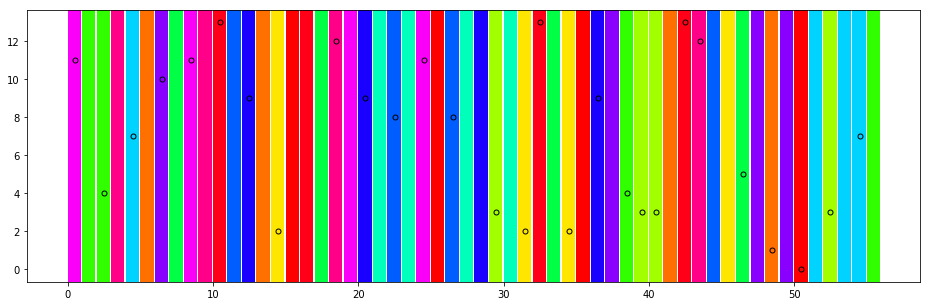

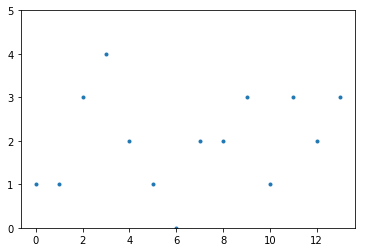

28.0/56 = 0.5


In [137]:
for c in ipc:
    print(c)
    for idx in ipc[c]:
        print("  {}:  {}".format(idx, ipc[c][idx]))

base_idx = int( start_t // dt )
plt.figure(figsize=(16, 5))
for i, cls in enumerate(test_labels):
    plt.axvspan(i, i+0.85, color=cmap(float(cls)/n_class), alpha=1.0)
    
for cls in sorted(ipc.keys()):
    for idx in sorted(ipc[cls].keys()):
        if len(ipc[cls][idx]):
            plt.plot(idx - base_idx+0.5, cls, '.', color=cmap(float(cls)/n_class),
                    markeredgewidth=1, markeredgecolor='black', markersize=10)

events = np.zeros(n_class)
for cls in sorted(ipc.keys()):
    for idx in sorted(ipc[cls].keys()):
        if len(ipc[cls][idx]):
            events[cls] += 1

plt.figure()
ax = plt.subplot(1, 1, 1)
plt.plot(np.arange(n_class), events, '.')
ax.set_ylim(0, 5)


# im = plt.imshow(mtx, cmap='rainbow', interpolation='none')
# plt.colorbar(im)
plt.show()
max_score = n_test * n_class
# this_score = np.sum(events) / max_score
this_score = analysis.individual_score(ipc, n_test, n_class)
print("{}/{} = {}".format( np.sum(events), max_score, this_score )) 


In [141]:
diff_class_vectors = [np.zeros(n_out, dtype='int') for _ in apc]

for c in apc:
    nids = list(apc[c].keys())
    if len(nids):
#         print(nids)
        diff_class_vectors[c][nids] += 1

any_zero = False
all_zero = False
for cls in sorted(ipc.keys()):
    for idx in sorted(ipc[cls].keys()):
        if len(ipc[cls][idx]) == 0:
            any_zero = True
            break
    if any_zero:
        break

for c in apc:
    nids = list(apc[c].keys())
    if len(nids) == 0:
        all_zero = True
print(any_zero, all_zero)
print(analysis.any_all_zero(apc, ipc))

True True
(True, True)


In [139]:
same_dist = analysis.same_class_distances(analysis.same_class_vectors(ipc, n_out))
same_fit = np.mean([np.mean(same_dist[c]) for c in same_dist])
print(same_dist)
print(same_fit)

{0: array([0., 0., 0., 0., 0., 0.]), 1: array([0., 0., 0., 0., 0., 0.]), 2: array([0., 0., 0., 0., 0., 0.]), 3: array([0., 0., 0., 0., 0., 0.]), 4: array([0., 0., 0., 0., 0., 0.]), 5: array([0., 0., 0., 0., 0., 0.]), 6: array([0., 0., 0., 0., 0., 0.]), 7: array([0., 0., 0., 0., 0., 0.]), 8: array([0., 0., 0., 0., 0., 0.]), 9: array([0., 0., 0., 0., 0., 0.]), 10: array([0., 0., 0., 0., 0., 0.]), 11: array([0., 0., 0., 0., 0., 0.]), 12: array([0., 0., 0., 0., 0., 0.]), 13: array([0., 0., 0., 0., 0., 0.])}
0.0


In [6]:

result_files = sorted(glob('./L2L-OMNIGLOT/run_results/*.npz'))
# result_files = sorted(glob('/home/gp283/titan/run_results/*.npz'))
tmp = np.load(result_files[0], allow_pickle=True)

class_data = {}
train_vecs_single = {}
train_vecs_accum = {}
accuracies = {}
for rf in result_files[-1:]:
    
    try:
        tmp = np.load(rf, allow_pickle=True)
        data.clear()
        for k in tmp:
            try:
                data[k] = tmp[k].item()
            except:
                data[k] = tmp[k]
    except:
        continue
    
    
    gen, ind = get_gen_ind(rf)
    labels  = data['input']['labels']
    
    
    duration = data['params']['sim']['duration']
    n_test = data['params']['sim']['test_per_class']
    sample_dt = data['params']['sim']['sample_dt']
    n_samples = data['params']['sim']['samples_per_class']
    n_class = data['params']['sim']['num_classes']
    n_train = 1 * n_samples # epochs * samples
    n_out = data['params']['sim']['output_size']
    
    
    total_lbl = len(labels)
    end = total_lbl -  (n_class * n_test)
    start = end - (n_class * n_train)
    unique, counts = np.unique(labels[start : end], return_counts=True)
    print(dict(zip(unique, counts)))
#     print(labels[start : end])
    print(total_lbl, start, end)
    
    plt.close('all')
    fig = plt.figure(figsize=(15, 3))
    ax = plt.subplot(1, 4, 1)
    im = plt.hist(labels, bins=n_class)

    ax = plt.subplot(1, 4, 2)
    im = plt.hist(labels[start:], bins=n_class)
    
    ax = plt.subplot(1, 4, 3)
    im = plt.hist(labels[start:end], bins=n_class)
    
    ax = plt.subplot(1, 4, 4)
    im = plt.hist(labels[end:], bins=n_class)

    plt.show()
    
    end_t = duration - sample_dt * n_class * n_test
    start_t = end_t - sample_dt * n_class * n_train
    
#     print(start_t, end_t)
    spikes = filter_spikes(data['recs']['output'][0]['spikes'], start_t, end_t)
#     print(spikes)
#     classes = spikes_to_classes(spikes, sample_dt, labels)
    vecs = spikes_to_vectors(spikes, start_t, end_t, sample_dt, labels, n_class, n_out)
    # not every set has the same number so reduce
#     n_train = 50
    rand_class = np.tile(np.arange(n_class), n_train)
    train_id = np.random.choice(len(rand_class), size=len(rand_class), replace=False)
    samp = train_id // n_class
    train_class = train_id % n_class
    train_vecs = [vecs[c][samp[i]].copy() for i, c in enumerate(train_class)]
    train_accums = accum_vectors(vecs)
    
    assert (n_class * n_train) == len(train_vecs), 'Not the same number of vectors'


    clf = KNeighborsClassifier()
#     clf = linear_model.LogisticRegression()
    clf.fit(train_vecs, train_class)
    
    v = data['analysis']['individual_per_class']['vectors']
#     print(v)
    if len(v):
        rand_class = np.tile(np.arange(n_class), n_test)
        test_id = np.random.choice(len(rand_class), size=len(rand_class), replace=False)
        samp = test_id // n_class
        test_class = test_id % n_class
        test_vecs = [v[c][samp[i]].copy() for i, c in enumerate(test_class)]
        score = clf.score(test_vecs, test_class)

        scores = class_data.get(gen, [])
        scores.append(score)
        class_data[gen] = scores

        accuracies[gen] = accuracy(train_accums, v)


plt.figure()
for k in class_data:
    plt.plot(k, np.mean(class_data[k]), '.')
plt.show()

<Figure size 432x288 with 0 Axes>

In [7]:
# print(train_accums)
print(accuracies)


{}


In [8]:

# result_files = sorted(glob('./L2L-OMNIGLOT/run_results/*.npz'))
# result_files = sorted(glob('/home/gp283/titan/run_results/*.npz'))
tmp = np.load(result_files[0], allow_pickle=True)
data = {}
class_data = {}
for rf in result_files[-1:]:
    
    try:
        tmp = np.load(rf, allow_pickle=True)
        data.clear()
        for k in tmp:
            try:
                data[k] = tmp[k].item()
            except:
                data[k] = tmp[k]
    except:
        continue
    
    gen, ind = get_gen_ind(rf)
    
    n_class = data['params']['sim']['num_classes']
    n_test = data['params']['sim']['test_per_class']
    
    n_train = n_test - 1
    
    train_vecs = data['analysis']['aggregate_per_class']['vectors'].copy()
    train_class = np.arange(n_class, dtype='int')
    v = data['analysis']['individual_per_class']['vectors']
    
    if len(v) == 0:
        continue
    
#     rand_class = np.tile(np.arange(n_class), n_train)
#     train_id = np.random.choice(len(rand_class), size=len(rand_class), replace=False)
#     samp = train_id // n_class
#     train_class = train_id % n_class
#     train_vecs = [v[c][samp[i]].copy() for i, c in enumerate(train_class)]
#     assert (n_class * n_train) == len(train_vecs), 'Not the same number of vectors'

#     test_class = np.arange(n_class, dtype='int')
#     test_vecs = [v[c][-1].copy() for c in test_class]
    
    rand_class = np.tile(np.arange(n_class), n_train)
    test_id = np.random.choice(len(rand_class), size=len(rand_class), replace=False)
    samp = test_id // n_class
    test_class = test_id % n_class
    test_vecs = [v[c][samp[i]].copy() for i, c in enumerate(test_class)]
    
    
    scores = class_data.get(gen, [])
    
#     clf = SVC(kernel="linear")#, C=0.025)
#     clf = SVC(gamma=2, C=1)
#     clf = KNeighborsClassifier()
#     clf = linear_model.LogisticRegression()
#     clf.fit(train_vecs, train_class)
    score = clf.score(test_vecs, test_class)
    
    scores.append(score)
    class_data[gen] = scores
    

/L2L-OMNIGLOT/run_results/data_gen0000000034_ind0000000001
./L2L-OMNIGLOT/run_results/data_gen0000000034_ind0000000001.npz ['gen0000000034', 'ind0000000001']


NameError: name 'clf' is not defined

In [ ]:
plt.figure()
for k in class_data:
    plt.plot(k, np.mean(class_data[k]), '.')
plt.show()